In [ ]:
# https://huggingface.co/HuggingFaceH4


In [ ]:
# https://github.com/yaodongC/awesome-instruction-dataset


In [1]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch
from easynmt import EasyNMT
from optimum.bettertransformer import BetterTransformer
from datasets import load_from_disk, load_dataset
import os
import pandas as pd

class Translator:
    def __init__(self, 
        model_name: str,
        device = 'cuda'
    ):
        self.model_name = model_name
        self.device = device
        self.model = None
        self.tokenizer = None
        self.init()
    
    def init(self):
        print("Init model.")
        if self.model_name == "facebook/nllb-200-3.3B":
            self.model = AutoModelForSeq2SeqLM.from_pretrained(
                self.model_name, 
                use_auth_token=True,
            )
            self.model = BetterTransformer.transform(self.model)
            self.model.eval()
            self.model = torch.compile(self.model)
            self.model = self.model.to(self.device)
            self.tokenizer = AutoTokenizer.from_pretrained(
                self.model_name,
                use_auth_token=True,
            )
        elif self.model_name == "facebook/wmt21-dense-24-wide-en-x":
            self.model = AutoModelForSeq2SeqLM.from_pretrained(
                self.model_name, 
                use_auth_token=True,
            )
            self.model = BetterTransformer.transform(self.model)
            self.model.eval()
            self.model = torch.compile(self.model)
            self.model = self.model.to(self.device)
            self.tokenizer = AutoTokenizer.from_pretrained(
                self.model_name,
                use_auth_token=True,
            )
        elif self.model_name == "opus-mt":
            self.model = EasyNMT(self.model_name)
            
        print("Model is initialized.")
    
    def translate(self, text: str):
        func_map = {
            "facebook/nllb-200-3.3B": self.nllb_translate,
            "opus-mt": self.opusmt_translate,
            "facebook/wmt21-dense-24-wide-en-x": self.wmt21_translate
        }
        
        with torch.no_grad():
            return func_map[self.model_name](text)
    
    def __call__(self, text: str):
        return self.translate(text=text)
    
    def nllb_translate(self, text: str):
        inputs = self.tokenizer(text, return_tensors="pt")
        inputs = self.to_device(inputs=inputs)
        translated_tokens = self.model.generate(
            **inputs, 
            forced_bos_token_id=self.tokenizer.lang_code_to_id["rus_Cyrl"],
        )
        return self.tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)[0]
    
    def opusmt_translate(self, text: str):
        return self.model.translate(
            text,
            source_lang="en" ,
            target_lang='ru'
        )

    def wmt21_translate(self, text):
        inputs = self.tokenizer(text, return_tensors="pt")
        inputs = self.to_device(inputs=inputs)
        translated_tokens = self.model.generate(
            **inputs, 
            forced_bos_token_id=self.tokenizer.get_lang_id("ru"),
        )
        return self.tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)[0]
    
    def to_device(self, inputs):
        for key in inputs.keys():
            inputs[key] = inputs[key].to(self.device)
        return inputs

/home/kosenko/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
EasyNMT("facebook/wmt21-dense-24-wide-en-x")

In [7]:
# 2 min 40 sec - 50
# model_name = "facebook/nllb-200-3.3B"
# 6 min 5 sec - 50
# model_name = "facebook/wmt21-dense-24-wide-en-x"
# 45 sec - 50
model_name = "opus-mt"
device = torch.device("cuda:0")
translator = Translator(model_name=model_name, device=device)

Init model.
Model is initialized.


In [8]:
translator("hello world")

/home/kosenko/miniconda3/lib/python3.10/site-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
/home/kosenko/miniconda3/lib/python3.10/site-packages/transformers/generation/utils.py:1336: UserWarning: Using `max_length`'s default (512) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


'Приветствую мир'

### databricks/databricks-dolly-15k

In [9]:
data = load_dataset("databricks/databricks-dolly-15k")
data


100%|██████████| 1/1 [00:00<00:00, 642.41it/s]


DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 15014
    })
})

In [10]:
data["train"][0]


{'instruction': 'When did Virgin Australia start operating?',
 'context': "Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route.[3] It suddenly found itself as a major airline in Australia's domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney.[4]",
 'response': 'Virgin Australia commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route.',
 'category': 'closed_qa'}

In [ ]:
base_folder = "/home/kosenko/deepspeed/DeepSpeedExamples/applications/DeepSpeed-Chat/training/step1_supervised_finetuning/datasets/translations_examples/"
model_path = model_name.replace("/", "_")
save_path = f"{base_folder}{model_path}.csv"

assert not os.path.isfile(save_path), f'File {model_path} exists'

fields = ["context", "instruction", "response"]

dataset_map = {item: [] for item in fields}
for thread in fields:
    dataset_map[f'{thread}_translated'] = []

for i, example in enumerate(data["train"]):
    print("Progress ",i)
    for field in fields:
        print(f"Field name: {field}")
        print("Original: ", example[field])
        text = example[field]
        translated = translator(text=text)
        print("Translated: ", translated)
        dataset_map[field].append(example[field])
        dataset_map[f'{field}_translated'].append(translated)
        print()
    print("==" * 100)

    if i > 50:
        break
pd.DataFrame(data=dataset_map).to_csv(save_path, index=False)


### OpenAssistant Conversations Dataset (OASST1)

In [10]:
import pandas as pd
dataset = pd.read_json(path_or_buf="/home/kosenko/deepspeed/DeepSpeedExamples/applications/DeepSpeed-Chat/training/step1_supervised_finetuning/datasets/pure_datasets/2023-04-12_oasst_all.messages.jsonl",lines=True)
dataset = dataset[dataset['lang'] == 'es']

message_tree_ids = dataset['message_tree_id'].unique()
# message_tree_ids = [list(dataset.query(f"message_tree_id == '{message_tree_id}'").sort_values("created_date")['text']) for message_tree_id in message_tree_ids]
len(message_tree_ids)

22308

In [7]:
# dataset['lang'].value_counts()

lang
es    43288
Name: count, dtype: int64

In [34]:
len(dataset)

72567

In [35]:
dataset.columns

Index(['message_id', 'user_id', 'created_date', 'text', 'role', 'lang',
       'review_count', 'review_result', 'deleted', 'synthetic', 'emojis',
       'labels', 'detoxify', 'message_tree_id', 'tree_state', 'parent_id',
       'rank', 'model_name'],
      dtype='object')

In [1]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("facebook/wmt21-dense-24-wide-en-x")



/home/kosenko/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:

lengths = []
max_len = 0
message_tree_ids_map = {}
# for i, message_tree_id in enumerate(message_tree_ids):
#     # print(message_tree_id)
#     texts = list(dataset.query(f"message_tree_id == '{message_tree_id}'").sort_values("created_date")['text'])
    
#     for message in texts:
#         print(message)
#         # lengths.append(len())
#         # input_ids = tokenizer(message, truncation=True, max_length=2048)['input_ids']
#         # max_len = max(len(input_ids), max_len)
#         print("="*100)
#     print("|"*100)
#     print("|"*100)
#     if i > 100:
#         break

for i in range(len(dataset)):
    ids = str(dataset.iloc[i]['message_tree_id'])
    if message_tree_ids_map.get(ids, None) is None:
        message_tree_ids_map[ids] = 1
    else:
        message_tree_ids_map[ids] += 1

In [12]:
message_tree_ids = []
for key in message_tree_ids_map.keys():
    if message_tree_ids_map.get(key) > 1:
        message_tree_ids.append(key)

In [25]:
# dataset = pd.read_json(path_or_buf="../datasets/pure_datasets/2023-04-12_oasst_ready.trees.jsonl",lines=True)
# dataset = dataset[dataset['lang'] == 'en']

In [9]:
import json
import pandas as pd
with open("../datasets/openass_translated_en2ru/openass_translated_en2ru.json") as f:
    data = json.load(f)
    data = json.loads(data)
en2ru_dataset = pd.DataFrame(data=data)

In [10]:
en2ru_dataset.columns

Index(['message_id', 'user_id', 'created_date', 'text', 'role', 'lang',
       'review_count', 'review_result', 'deleted', 'synthetic', 'emojis',
       'labels', 'detoxify', 'message_tree_id', 'tree_state', 'parent_id',
       'rank', 'model_name', 'text_translated'],
      dtype='object')

In [ ]:
message_tree_ids = en2ru_dataset['message_tree_id'].unique()
for i in range(len(message_tree_ids)):
    message_tree_id = message_tree_ids[i]
    texts = list(en2ru_dataset.query(f"message_tree_id == '{message_tree_id}'").sort_values("created_date")['text_translated'])
    print(message_tree_id)
    for j in range(len(texts)):
        text = texts[j]
        print(text)
        print("-"*10)
    print("|||"*100)
    if i > 100:
        break

In [11]:
import json
import pprint

with open('../datasets/pure_datasets/2023-04-12_oasst_ready.trees.jsonl', 'r') as json_file:
    json_list = list(json_file)

conversation_example = None
for i, json_str in enumerate(json_list):
    record = json.loads(json_str)
    # if len(result['prompt']['replies']) == 2 and result['prompt']['lang'] == 'en':
    if record['message_tree_id'] == 'ca4d0c93-220b-4861-87c1-bdb44cd13f72':
        # print(record['prompt']['text'])
        # pprint.pprint(record)
        conversation_example = record 
        break
    
    # if i > 20:
        # break

In [12]:
from collections.abc import Iterable

def flatten(xs):
    for x in xs:
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            yield from flatten(x)
        else:
            yield x
            
# https://codebeautify.org/python-formatter-beautifier - for debug
def get_all_threads(sample):
    # debug
    # initial_message = f"{sample['role'].upper()} {sample['text']} |"
    initial_message = f"{sample['message_id']} "
    def recursive_helper(node, current_path):
        
        if len(node['replies']) == 0:
            if node['role'] == "assistant":
                # debug
                # current_path += f"\n|||||||||||||\n {node['role'].upper()} {node['text']}"
                current_path += f" {node['message_id']}"
            
            return current_path + " <END>"
        
        current_path += f" {node['message_id']}"
        paths = []
        for reply in node['replies']:
            if node['labels']['spam']['value'] < 0.4:
                path = recursive_helper(reply, current_path)
                paths.append(path) 
        return paths
    
    threads = []
    for reply in sample['replies']:
        path = recursive_helper(reply, initial_message) 
        threads.append(path)
    
    threads = flatten(threads)
    conversations = []
    for thread in threads:
        if "<END>" in thread:
            # debug
            # pprint.pprint(thread)
            # print(thread.split())
            conversation = thread.split()[:-1]
            conversations.append(conversation) 
    
    return conversations
    
# all_threads = get_all_threads(sample=conversation_example['prompt'])
# all_threads

In [13]:
en2ru_dataset_messages_map = {}
for i in range(len(en2ru_dataset)):
    message_id = en2ru_dataset.iloc[i]['message_id']
    # text_translated = en2ru_dataset.iloc[i]['text_translated']
    text_translated = en2ru_dataset.iloc[i]['text']
    role = en2ru_dataset.iloc[i]["role"]
    en2ru_dataset_messages_map[message_id] = {
        "role": role, 
        "text": text_translated
    }

In [7]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("facebook/xglm-4.5B")

In [14]:
conversations_paths = {}
errors = 0
total_convs = 0

import matplotlib.pyplot as plt
import numpy as np
def visualize_hist(x: np.ndarray, title: str):
    fig, ax = plt.subplots()
    ax.hist(x,linewidth=0.5, edgecolor="white", bins=300)
    plt.gca().set(title=title, ylabel='Frequency')
    plt.show()

lengths = []

new_dataset = []

for i, json_str in enumerate(json_list):
    record = json.loads(json_str)
    if len(record['prompt']['replies']) >= 0 and record['prompt']['lang'] == 'en':
        
        message_tree_id = record['message_tree_id']
        conversations_paths[message_tree_id] = []
        
        all_threads = get_all_threads(record['prompt'])
        conversations_paths[message_tree_id] = all_threads

        # TODO: написать преобразователь из этих полученных путей
        # в реальный датасет, используя мой переведенный
        for thread in all_threads:
            total_convs += 1
            try:
                # conv = "\n\n\n".join([en2ru_dataset_messages_map[mess]['text'] for mess in thread])
                conv = [en2ru_dataset_messages_map[mess] for mess in thread]
                conversation = []
                for mess_id in thread:
                    message = en2ru_dataset_messages_map[mess_id]['text']
                    role = en2ru_dataset_messages_map[mess_id]['role']
                    conversation.append({
                        "message_id": mess_id,
                        "message": message,
                        "role": role
                    })
                new_dataset.append(conversation)
                # lengths.append(len(tokenizer(conv)['input_ids']))
            except:
                errors += 1
            # pprint.pprint(conv)
            # print("="*100)
        # if i > 100:
            # break
    
errors, total_convs

(12, 20988)

In [15]:
len(new_dataset)

20976

In [16]:
new_dataset[0]

[{'message_id': '6ab24d72-0181-4594-a9cd-deaf170242fb',
  'message': 'Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research.',
  'role': 'prompter'},
 {'message_id': 'c8e83833-ecbc-44fe-b6db-735228c25a1c',
  'message': '"Monopsony" refers to a market structure where there is only one buyer for a particular good or service. In economics, this term is particularly relevant in the labor market, where a monopsony employer has significant power over the wages and working conditions of their employees. The presence of a monopsony can result in lower wages and reduced employment opportunities for workers, as the employer has little incentive to increase wages or provide better working conditions.\n\nRecent research has identified potential monopsonies in industries such as retail and fast food, where a few large companies control a significant portion of 

In [17]:
import json
with open("../datasets/openass_translated_en2ru/openass_en_threads_21k.json", 'w', encoding='utf-8') as outfile:
	json.dump(new_dataset, outfile)

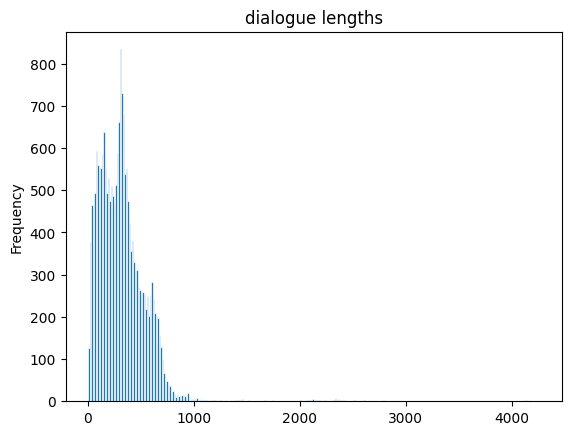

In [13]:
visualize_hist(lengths, "dialogue lengths")

In [81]:
len(conversations_paths.keys())

3670

## chip2_instruct_alpha

In [15]:
from datasets import load_dataset
import pandas as pd
# load_dataset("json", "../datasets/pure_datasets/chip2_instruct_alpha/chip2_instruct_alpha_v6a_2.json")
data_1 = pd.read_json(path_or_buf="../datasets/chip2_instruct_alpha/chip2_instruct_alpha_v6a_1_translated.json")
data_2 = pd.read_json(path_or_buf="../datasets/chip2_instruct_alpha/chip2_instruct_alpha_v6a_2_translated.json")
data_3 = pd.read_json(path_or_buf="../datasets/chip2_instruct_alpha/chip2_instruct_alpha_v6a_3_translated.json")
data_4 = pd.read_json(path_or_buf="../datasets/chip2_instruct_alpha/chip2_instruct_alpha_v6a_4_translated.json")

In [17]:
len(data_2)

54000

In [18]:
data_1

,user,bot,user_translated,bot_translated
0,What are some tips for creating a successful b...,\n1. Research your target market: Understand w...,Каковы некоторые советы для создания успешного...,"1. Изучите свой целевой рынок: Поймите, кому в..."
1,Describe the location where you find yourself ...,Sturdy rectory tables and low benches offer a ...,"Опишите место, где вы оказываетесь в безмятежн...",Прочные приходские столы и низкие скамейки пре...
2,I am interested in gaining an understanding of...,Some topics you could research on the banking ...,Я заинтересован в получении понимания банковск...,"Некоторые темы, которые вы могли бы исследоват..."
3,I want to find out more about a certain type o...,That sounds like a great idea. What kind of bi...,Я хочу узнать больше об определенном типе птиц.,Звучит как отличная идея.Какая птица вам интер...
4,round number to nearest integer,Here is some code to round number 4.0005 up to...,Округление до ближайшего целого числа,Вот некоторый код для округления числа 4.0005 ...
...,...,...,...,...
53995,"In spring, a family planted trees to capture t...",How many peaches were planted? ** The number o...,"Весной семья посадила деревья, чтобы захватить...",Сколько было посажено персиков? ** Количество ...
53996,How can I make sure my child is prepared to en...,Start by talking with your child about what th...,"Как я могу убедиться, что мой ребенок готов к ...","Начните с разговора с вашим ребенком о том, чт..."
53997,Who was the first person to live in the Upper ...,The first person to live in the Upper West Sid...,"Кто был первым человеком, который жил в Верхне...","Первым человеком, который жил в Верхнем Вест-С..."
53998,Generate for me a description of a spooky cour...,Entry through an ebonwood arch muffles unwelco...,Сгенерируйте для меня описание жуткого двора с...,Вход через эбоновую арку заглушает нежелательн...


In [19]:
lengths = []
for i in range(len(data_1)):
    format_func = lambda u, b: f'User: {u} Bot: {b}'
    tok_len = lambda prompt: len(tokenizer(prompt)['input_ids'])
    user_1 = data_1.iloc[i]['user_translated']
    bot_1 = data_1.iloc[i]['bot_translated']
    user_2 = data_2.iloc[i]['user_translated']
    bot_2 = data_2.iloc[i]['bot_translated']
    user_3 = data_3.iloc[i]['user_translated']
    bot_3 = data_3.iloc[i]['bot_translated']
    
    lengths.append(tok_len(format_func(user_1, bot_1)))
    lengths.append(tok_len(format_func(user_2, bot_2)))
    lengths.append(tok_len(format_func(user_3, bot_3)))
    

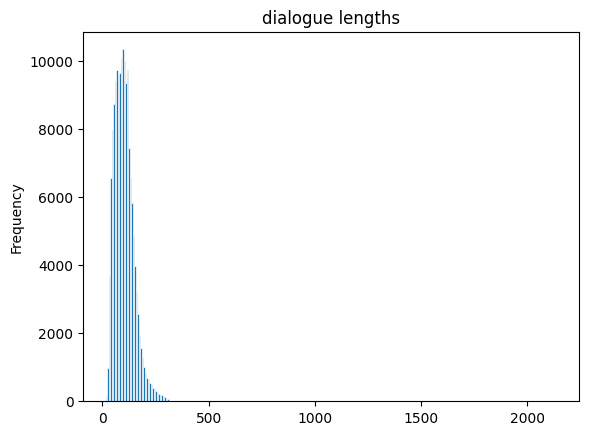

In [20]:
visualize_hist(lengths, "dialogue lengths")

In [24]:
concat_chip2 = pd.concat([
	data_1,
	data_2,
	data_3,
	data_4,
], ignore_index=True)

concat_chip2.to_json(path_or_buf="../datasets/chip2_instruct_alpha/chip2_instruct_alpha_all_translated.json")

In [55]:
instruction_dataset = []
for i in range(len(data)):
    line = data.iloc[i][0]
    user, bot = line.split("Chip2: ")
    user = user.replace("User: ", "")
    user = user.replace("\n\n", "")
    bot = bot.replace("<|endoftext|>", "")
    instruction_dataset.append({
        "user": user,
        "bot": bot
    })

In [56]:
instruction_dataset[1000]

{'user': "I'm looking for a new job. What questions should I ask a potential employer during an interview?",
 'bot': '\n1. What is the job role and what responsibilities does it involve?\n2. What skills and experiences are you seeking in the most successful candidate? \n3. What challenges will I face in this role and what support systems are available to help me meet these challenges?\n4. How does this job fit in the overall organizational structure?\n5. What opportunities for professional development and growth are available?\n6. What are the expectations for performance in the role?\n7. How will success in this role be measured?\n8. How often will I receive feedback on my performance?\n9. How quickly is the company expecting me to transition into this role and hit the ground running?\n10. What advantages would I bring to the team that would make me the right fit for the job?'}

In [52]:
import json
with open("../datasets/pure_datasets/chip2_instruct_alpha/chip2_instruct_alpha_v6a_4_formatted.json", 'w', encoding='utf-8') as outfile:
	json.dump(instruction_dataset, outfile)

In [40]:
# translated_data = pd.read_json(path_or_buf="/home/kosenko/deepspeed/DeepSpeedExamples/applications/DeepSpeed-Chat/training/step1_supervised_finetuning/datasets/chip2_instruct_alpha/chip2_instruct_alpha_v6a_1_translated.json")
# translated_data.to_csv("./test.csv")

In [1]:
import json

with open("../datasets/chip2_instruct_alpha/chip2_instruct_alpha_v6a_2_translated.json") as f:
    data = json.load(f)
    # data = json.loads(data)

In [2]:
import pprint
for i, thread in enumerate(data):
    pprint.pprint(thread)
    if i > 100:
    	break
# len(data)
    

{'bot': 'A will is a legal document that specifies how your property should be '
        'distributed after you die. It can also specify who should care for '
        "any children or other dependents you may have. It's important to make "
        'sure that your will is valid and up-to-date, since the laws governing '
        'wills vary from state to state.',
 'bot_translated': 'Завещание - это юридический документ, который определяет, '
                   'как ваше имущество должно быть распределено после вашей '
                   'смерти. В нем также может быть указано, кто должен '
                   'заботиться о любых детях или других иждивенцах, которые у '
                   'вас могут быть. Важно убедиться, что ваша воля '
                   'действительна и актуальна, поскольку законы, регулирующие '
                   'завещания, варьируются от штата к штату.',
 'user': "I've heard that it's a good idea to have a will. What is a will?",
 'user_translated': 'Я слышал, что х

## dolly translated

In [1]:
import pandas as pd
data = pd.read_json(path_or_buf="../datasets/dolly_translated/dolly_translated_fixed.json")

In [2]:
data.head(5)

,instruction,context,response,category,context_translated,instruction_translated,response_translated
0,When did Virgin Australia start operating?,"Virgin Australia, the trading name of Virgin A...",Virgin Australia commenced services on 31 Augu...,closed_qa,"Virgin Australia, торговое название Virgin Aus...",Когда Virgin Australia начала работать?,Virgin Australia начала полеты 31 августа 2000...
1,Which is a species of fish? Tope or Rope,,Tope,classification,,Что это за вид рыбы? Tope или Rope,Топик
2,Why can camels survive for long without water?,,Camels use the fat in their humps to keep them...,open_qa,,Почему верблюды могут долго обходиться без воды?,"Верблюды используют жир в своих горбах, чтобы ..."
3,"Alice's parents have three daughters: Amy, Jes...",,The name of the third daughter is Alice,open_qa,,"У родителей Элис три дочери: Эми, Джесси, и ка...",Имя третьей дочери - Алиса
4,When was Tomoaki Komorida born?,Komorida was born in Kumamoto Prefecture on Ju...,"Tomoaki Komorida was born on July 10,1981.",closed_qa,Коморида родился в префектуре Кумамото 10 июля...,Когда родился Томоаки Коморида?,Томоаки Коморида родился 10 июля 1981 года.


In [3]:
dolly_augumented = []

for i in range(len(data)):
    # context_translated = data.iloc[i]['context_translated']
    # instruction_translated = data.iloc[i]['instruction_translated']
    # response_translated = data.iloc[i]['response_translated']
    context = data.iloc[i]['context']
    instruction = data.iloc[i]['instruction']
    response = data.iloc[i]['response']

    if context.strip() != "":
        prompt = f"Human: {context} {instruction} Assistant: {response}"
        dolly_augumented.append(prompt)
        prompt = f"Human: {instruction} {context} Assistant: {response}"
        dolly_augumented.append(prompt)
    else:
        prompt = f"Human: {instruction} Assistant: {response}"
        dolly_augumented.append(prompt)
        
    

In [5]:
dolly_augumented[10]

"Human: Given a reference text about Lollapalooza, where does it take place, who started it and what is it? Lollapalooza /ˌlɒləpəˈluːzə/ (Lolla) is an annual American four-day music festival held in Grant Park in Chicago. It originally started as a touring event in 1991, but several years later, Chicago became its permanent location. Music genres include but are not limited to alternative rock, heavy metal, punk rock, hip hop, and electronic dance music. Lollapalooza has also featured visual arts, nonprofit organizations, and political organizations. The festival, held in Grant Park, hosts an estimated 400,000 people each July and sells out annually.[4] Lollapalooza is one of the largest and most iconic music festivals in the world and one of the longest-running in the United States.[5][6]\n\nLollapalooza was conceived and created in 1991 as a farewell tour by Perry Farrell, singer of the group Jane's Addiction. Assistant: Lollapalooze is an annual musical festival held in Grant Park i

In [4]:
len(dolly_augumented)

19612

In [6]:
import json

with open("../datasets/dolly_translated/dolly_original_augumented.json", 'w') as f:
    json.dump(dolly_augumented, f)

### read datasets

In [18]:
import json

# pd.read_json(path_or_buf="../datasets/dolly_translated/dolly_translated_augumented.json")
# with open("../datasets/dolly_translated/dolly_translated_augumented.json") as f:
with open("../datasets/dolly_translated/dolly_original_augumented.json") as f:
    dolly_translated_augumented = json.load(f)
dolly_translated_augumented[1]

"Human: When did Virgin Australia start operating? Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route.[3] It suddenly found itself as a major airline in Australia's domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney.[4] Assistant: Virgin Australia commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route."

In [19]:
import pandas as pd
chip2_instruct_alpha_all_translated = pd.read_json(path_or_buf="../datasets/chip2_instruct_alpha/chip2_instruct_alpha_all_translated.json")

chip2_instruct_alpha_all_translated.iloc[1]

user               Describe the location where you find yourself ...
bot                Sturdy rectory tables and low benches offer a ...
user_translated    Опишите место, где вы оказываетесь в безмятежн...
bot_translated     Прочные приходские столы и низкие скамейки пре...
Name: 1, dtype: object

In [20]:
with open("../datasets/openass_translated_en2ru/openass_en_threads_21k.json") as f:
    openass_en2ru_threads_21k = json.load(f)
openass_en2ru_threads_21k[10]

[{'message_id': '7cce4047-8f87-42c4-9d75-a590c02be5b1',
  'message': 'I want to start doing astrophotography as a hobby, any suggestions what could i do?',
  'role': 'prompter'},
 {'message_id': '19cb94ab-d6ab-4dbd-b408-70ffbd9b595c',
  'message': "Getting started in astrophotography can seem daunting, but with some patience and practice, you can become a master of the craft. To begin, you'll need a good camera and lens, a tripod, and a dark sky location free of light pollution. You will also need to learn about the basics of astrophotography, such as what camera settings to use, how to capture star trails, and the best techniques for tracking celestial objects. You can also purchase or rent different types of telescopes, depending on what types of objects you want to capture. Additionally, it's important to keep up with the latest astrophotography news and trends. Once you have the necessary equipment and knowledge, you can start shooting and experimenting with different techniques to

### save to huggingface datasets format

In [22]:
import pandas as pd
openass_prompt_dataset = []
get_role = lambda x: "Human:" if x["role"] == "prompter" else "Assistant:"

for thread in openass_en2ru_threads_21k:
    prompt = [f'{get_role(item)} {item["message"].strip()}' for item in thread]
    prompt = " ".join(prompt)
    # print(prompt)
    # break
    openass_prompt_dataset.append({'prompt':prompt})
    
openass_prompt_dataset[10]

{'prompt': "Human: I want to start doing astrophotography as a hobby, any suggestions what could i do? Assistant: Getting started in astrophotography can seem daunting, but with some patience and practice, you can become a master of the craft. To begin, you'll need a good camera and lens, a tripod, and a dark sky location free of light pollution. You will also need to learn about the basics of astrophotography, such as what camera settings to use, how to capture star trails, and the best techniques for tracking celestial objects. You can also purchase or rent different types of telescopes, depending on what types of objects you want to capture. Additionally, it's important to keep up with the latest astrophotography news and trends. Once you have the necessary equipment and knowledge, you can start shooting and experimenting with different techniques to get the best results. Human: Can you tell me more?  What would you recommend as a basic set of equipment to get started with?  How muc

In [23]:
len(openass_prompt_dataset)

20976

In [24]:
from datasets import Dataset
openass_prompt_dataset = Dataset.from_list(openass_prompt_dataset)
openass_prompt_dataset.save_to_disk("../datasets/prompt_datasets/openass_prompt_dataset_en")

/home/kosenko/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
dolly_translated_prompt = [{'prompt': item} for item in dolly_translated_augumented]
print(dolly_translated_prompt[10])
dolly_translated_prompt = Dataset.from_list(dolly_translated_prompt)
dolly_translated_prompt.save_to_disk("../datasets/prompt_datasets/dolly_original_prompt")

{'prompt': "Human: Given a reference text about Lollapalooza, where does it take place, who started it and what is it? Lollapalooza /ˌlɒləpəˈluːzə/ (Lolla) is an annual American four-day music festival held in Grant Park in Chicago. It originally started as a touring event in 1991, but several years later, Chicago became its permanent location. Music genres include but are not limited to alternative rock, heavy metal, punk rock, hip hop, and electronic dance music. Lollapalooza has also featured visual arts, nonprofit organizations, and political organizations. The festival, held in Grant Park, hosts an estimated 400,000 people each July and sells out annually.[4] Lollapalooza is one of the largest and most iconic music festivals in the world and one of the longest-running in the United States.[5][6]\n\nLollapalooza was conceived and created in 1991 as a farewell tour by Perry Farrell, singer of the group Jane's Addiction. Assistant: Lollapalooze is an annual musical festival held in G

In [29]:
dolly_translated_prompt[0]

{'prompt': "Human: Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route.[3] It suddenly found itself as a major airline in Australia's domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney.[4] When did Virgin Australia start operating? Assistant: Virgin Australia commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route."}

In [32]:
chip2_instruct_alpha_prompt = []
for i in range(len(chip2_instruct_alpha_all_translated)):
    # user = chip2_instruct_alpha_all_translated.iloc[i]['user_translated']
    # bot = chip2_instruct_alpha_all_translated.iloc[i]['bot_translated']
    user = chip2_instruct_alpha_all_translated.iloc[i]['user']
    bot = chip2_instruct_alpha_all_translated.iloc[i]['bot']
    prompt = f"Human: {user} Assistant: {bot}"
    # print(prompt)
    # break
    # if 'chatbot' in f'{user}{bot}'.lower() or 'ai' in f'{user}{bot}'.lower():
    #     print(user)
    #     print(bot)
    #     # break
    #     print("---"*100)
    chip2_instruct_alpha_prompt.append({'prompt': prompt})

In [33]:
chip2_instruct_alpha_prompt[100]

{'prompt': "Human: I'm thinking about getting my first tattoo. Where should I start looking for inspiration? Assistant: You can look online to find images of tattoos that you like, or check out the work of tattoo artists who specialize in certain styles. There are also plenty of books and magazines dedicated to tattoos, so those could be good resources as well."}

In [34]:
chip2_instruct_alpha_prompt = Dataset.from_list(chip2_instruct_alpha_prompt)
chip2_instruct_alpha_prompt.save_to_disk("../datasets/prompt_datasets/chip2_instruct_alpha_prompt_en/")

In [35]:
len(chip2_instruct_alpha_prompt) + len(dolly_translated_prompt) + len(openass_prompt_dataset)

250877